# On The Importance of Confidence Intervals

In this notebook, I will walk through the entire process of how one would go about answering a certain hypothesis with the Department of Education CollegeScoreCard Report, and then demonstrate the dangers behind trusting averages and how graphs can lie to us.

The idea for this note book resulted from me having this actual hypothesis, finding the data, testing it, and feeling that sense of elation and success when I thought I had discovered a previously undiscussed relationship between certain variables, only to have it crash down when I realized the underlying data was pointing in a different direction. Curious to see what went wrong? Keep reading on!

## An Analysis of Dept. of Edu. College ScoreCard 
### What is the Relationship between School Prestige(admission rate), School rigor(Average Admitted SAT Score), how STEM-y a school is(% of majors graduated that are STEM), and post-graduate earnings?

In [1]:
#Importing Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
#plot graphs with 538 styling
style.use('fivethirtyeight')

In [2]:
#Importing data
#due to size of file, we will only import certain columns which are relevant to this analysis
relev_col = [0,1,2,3,4,5]+list(range(36,99))+list(range(1637,1645))
#we use the 2013-2014 data because it is the most recent dataset with median earning data
df = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2013_14_PP.csv',usecols=relev_col)
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ADM_RATE,ADM_RATE_ALL,SATVR25,SATVR75,...,PCIP52,PCIP54,COUNT_WNE_P10,MN_EARN_WNE_P10,MD_EARN_WNE_P10,PCT10_EARN_WNE_P10,PCT25_EARN_WNE_P10,PCT75_EARN_WNE_P10,PCT90_EARN_WNE_P10,SD_EARN_WNE_P10
0,100654,100200,1002,Alabama A & M University,Normal,AL,0.8989,0.8989,370.0,450.0,...,0.1457,0.0000,1741,34300,29900,NaN,17200,45100,NaN,25300
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,0.8673,0.8673,520.0,640.0,...,0.1765,0.0212,3474,46400,40200,NaN,24900,57600,NaN,36300
2,100690,2503400,25034,Amridge University,Montgomery,AL,NaN,NaN,NaN,NaN,...,0.0685,0.0000,168,46100,40100,NaN,22900,59900,NaN,34900
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,0.8062,0.8062,510.0,640.0,...,0.2247,0.0118,1361,50500,45600,NaN,27300,70200,NaN,32700
4,100724,100500,1005,Alabama State University,Montgomery,AL,0.5125,0.5125,380.0,480.0,...,0.1068,0.0067,1977,29500,26700,NaN,14800,40800,NaN,20500


In [3]:
#Importing CIP Codes
CIP = pd.read_csv('STEM_CIP_NSF_DHS.csv')
CIP.columns = CIP.iloc[0,:]
CIP = CIP.drop(0,axis=0)
CIP.head()

,DHS,NSF
1,1,1
2,3,3
3,4,4
4,9,11
5,10,14


The PCIP classes in df describe the % of degrees granted by each institution that fall under the given CIP topic area. To quantify which majors are STEM-oriented, we manually scraped data from the Department of Homeland Security(DHS) and National Science Foundation(NSF) and aggregated the data in the above csv. You can find our NSF and DHS sources in the github as well. We then take the intersection of the two lists and consider that set of CIP codes as STEM fields. 

In [4]:
#takes only CIP codes that are in both the DHS and NSF categorizations
STEM_CIP = list(set(CIP.iloc[:,0]).intersection(CIP.iloc[:,1]))
#convert STEM_CIP to same column formatting as in df
def PCIP_format(entry):
    if len(entry)==1:
        return 'PCIP0'+entry
    else:
        return 'PCIP' + entry
PCIP = [PCIP_format(code) for code in STEM_CIP]

In [5]:
#Calculate the Percent of Majors graduated that are STEM
df.loc[:,'PCT_STEM'] = df[PCIP].sum(axis=1)
df = df.dropna(subset=['PCT_STEM'],axis=0)
#convert to numeric type
for col in df.iloc[:,6:].columns:
    df[col] = pd.to_numeric(df[col],errors='coerce')

In [6]:
#drop any rows with nan values for SAT_AVG
df = df.dropna(subset=['SAT_AVG','ADM_RATE','MD_EARN_WNE_P10'],axis=0)
#sort by sat scores
df = df.sort_values(by='SAT_AVG',ascending=True)
df = df.reset_index(drop=True)
assert df[df[['ADM_RATE','SAT_AVG','MD_EARN_WNE_P10']].isnull().values].empty==True
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ADM_RATE,ADM_RATE_ALL,SATVR25,SATVR75,...,PCIP54,COUNT_WNE_P10,MN_EARN_WNE_P10,MD_EARN_WNE_P10,PCT10_EARN_WNE_P10,PCT25_EARN_WNE_P10,PCT75_EARN_WNE_P10,PCT90_EARN_WNE_P10,SD_EARN_WNE_P10,PCT_STEM
0,176318,243300,2433,Rust College,Holly Springs,MS,0.1386,0.1386,310.0,360.0,...,0.0000,416.0,25100.0,22900.0,NaN,12900.0,34400.0,NaN,17200.0,0.5584
1,220598,349900,3499,Lane College,Jackson,TN,0.4916,0.4916,360.0,510.0,...,0.0000,506.0,25000.0,23300.0,NaN,12500.0,33600.0,NaN,18000.0,0.5550
2,198862,294200,2942,Livingstone College,Salisbury,NC,0.7122,0.7122,320.0,410.0,...,0.0000,439.0,24200.0,21400.0,NaN,11700.0,32900.0,NaN,17600.0,0.3676
3,111966,1036500,10365,Charles R Drew University of Medicine and Science,Los Angeles,CA,0.8889,0.8889,348.0,405.0,...,0.0000,166.0,70900.0,61700.0,NaN,28400.0,105200.0,NaN,51600.0,0.0000
4,199582,296800,2968,Saint Augustine's University,Raleigh,NC,0.6738,0.6738,330.0,423.0,...,0.0175,815.0,28300.0,25100.0,NaN,14300.0,37600.0,NaN,20100.0,0.3685


In [7]:
#further narrow our dataframe down to the most relevant columns for analysis
df_2 = df.iloc[:,[0,1,2,3,4,5,6,29,-6,-5,-4,-3,-2,-1,-7,-8]]
df_2.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ADM_RATE,SAT_AVG,PCT10_EARN_WNE_P10,PCT25_EARN_WNE_P10,PCT75_EARN_WNE_P10,PCT90_EARN_WNE_P10,SD_EARN_WNE_P10,PCT_STEM,MD_EARN_WNE_P10,MN_EARN_WNE_P10
0,176318,243300,2433,Rust College,Holly Springs,MS,0.1386,666.0,NaN,12900.0,34400.0,NaN,17200.0,0.5584,22900.0,25100.0
1,220598,349900,3499,Lane College,Jackson,TN,0.4916,716.0,NaN,12500.0,33600.0,NaN,18000.0,0.5550,23300.0,25000.0
2,198862,294200,2942,Livingstone College,Salisbury,NC,0.7122,723.0,NaN,11700.0,32900.0,NaN,17600.0,0.3676,21400.0,24200.0
3,111966,1036500,10365,Charles R Drew University of Medicine and Science,Los Angeles,CA,0.8889,735.0,NaN,28400.0,105200.0,NaN,51600.0,0.0000,61700.0,70900.0
4,199582,296800,2968,Saint Augustine's University,Raleigh,NC,0.6738,749.0,NaN,14300.0,37600.0,NaN,20100.0,0.3685,25100.0,28300.0


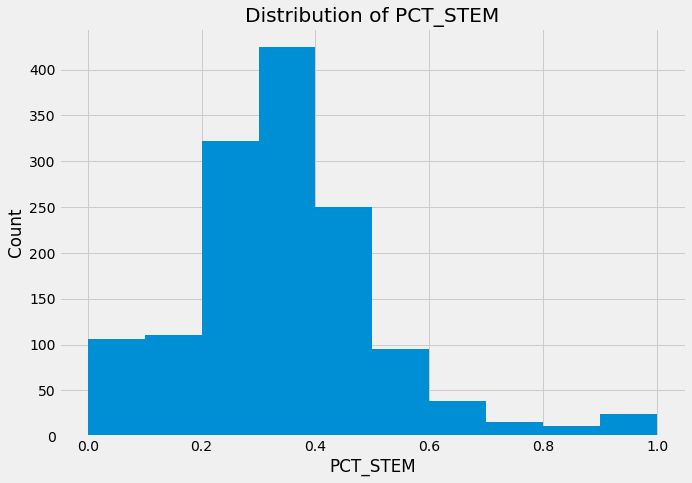

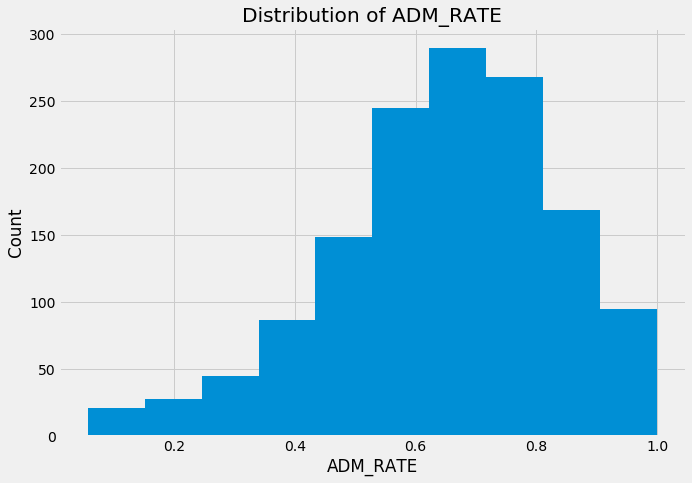

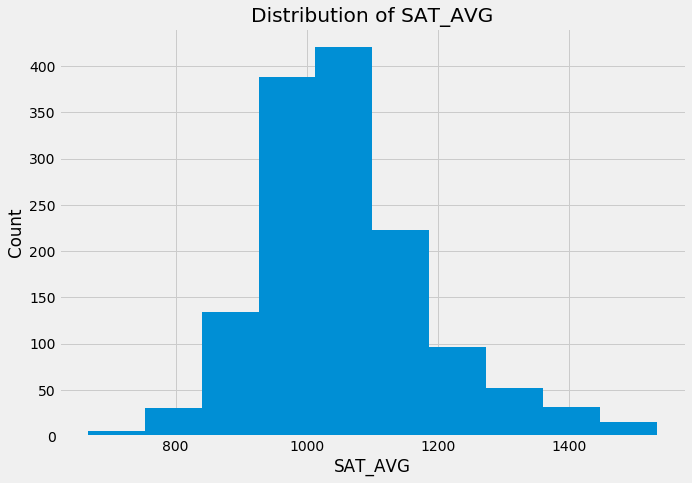

In [8]:
#Examining the distribution of certain columns
def distplotter(column):
    fig,ax = plt.subplots(figsize=(10,7))
    plt.hist(column)
    plt.ylabel('Count')
    plt.xlabel(column.name)
    ax.set_title('Distribution of '+column.name)
distplotter(df_2['PCT_STEM'])
distplotter(df_2['ADM_RATE'])
distplotter(df_2['SAT_AVG'])

We want to examine how School Prestige(as measured by admission rate, ADM_RATE), Major(as measured by a proxy variable of what % of people graduate with STEM Majors, PCT_STEM), and Post-Graduate Median Earnings after 10 years(MD_EARN_WNE_P10). 
Now SAT has been weakly correlated with IQ and income, so we want to separate this factor out. The way we do this is by binning schools based on their SAT_AVG.

In [9]:
SAT_6_8 = df_2[df_2['SAT_AVG']<800]
SAT_8_10 = df_2[(df_2['SAT_AVG']<1000)&(df_2['SAT_AVG']>800)]
SAT_10_12 = df_2[(df_2['SAT_AVG']<1200)&(df_2['SAT_AVG']>1000)]
SAT_12_14 = df_2[(df_2['SAT_AVG']<1400)&(df_2['SAT_AVG']>1200)]
SAT_14_16 = df_2[df_2['SAT_AVG']>1400]
SAT = [SAT_6_8,SAT_8_10,SAT_10_12,SAT_12_14,SAT_14_16]
#number of schools in each bin
counts = [len(x) for x in SAT]
counts += [len(df_2)]
print('Number of School in each Bin')
print(counts)

Number of School in each Bin
[16, 462, 741, 144, 28, 1397]


The class imbalance here should be obvious - most schools have a AVG_SAT in the middle with a few schools that score very highly and some that score very low. We should expect then that students at schools with very high SAT scores on average should already go on to do very well regardless of school/major. For a discussion on this, see the Robustness Check Ipython Notebook, which examines whether using a larger dataset( e.g more years) affects our results.

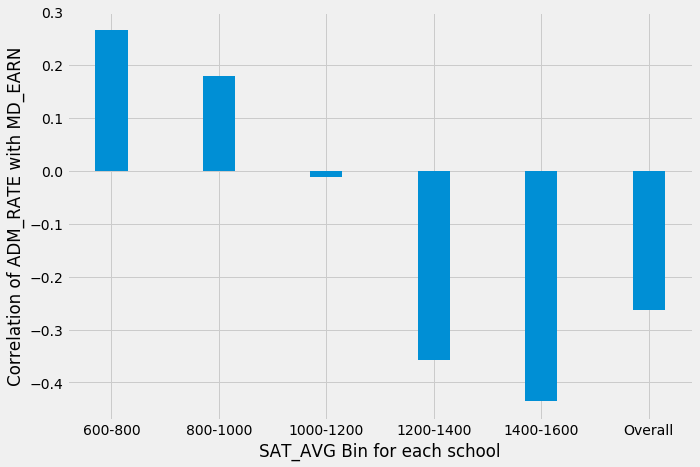

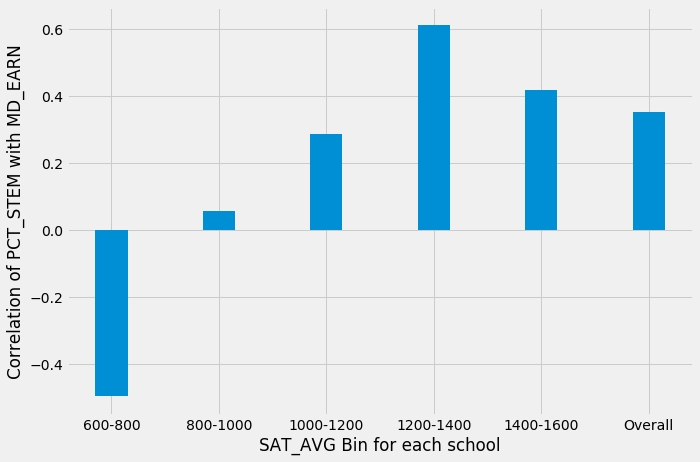

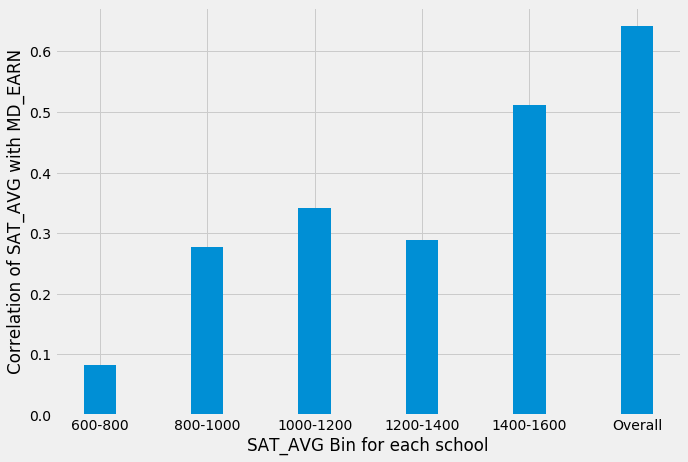

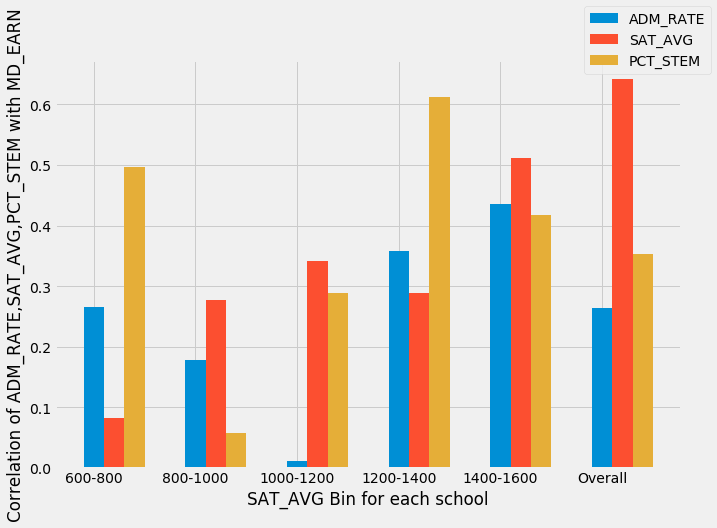

In [13]:
def result_plotter(SAT,corr_factor='ADM_RATE'):
    '''plots correlation of corr_factor with MD_EARN_WNE_P10(median post-graduate earning after 10 years) based on SAT bins
    organized in SAT as list'''
    import seaborn as sns
    def correlator(SAT):
        corr = []
        for idx in range(len(SAT)):
            df = SAT[idx]
            corr.append(np.corrcoef(df[corr_factor],df['MD_EARN_WNE_P10'])[0][1])
        #overall correlation
        df_total = pd.concat(SAT)
        corr.append(np.corrcoef(df_total[corr_factor],df_total['MD_EARN_WNE_P10'])[0][1])
        return corr
    corr = correlator(SAT)
    #plotting
    fig,ax = plt.subplots(figsize=(10,7))
    plt.bar(x=np.arange(len(corr)),height=corr,width=0.3)
    plt.ylabel('Correlation of '+corr_factor+' with MD_EARN')
    plt.xlabel('SAT_AVG Bin for each school')
    plt.xticks(range(len(corr)),['600-800','800-1000','1000-1200','1200-1400','1400-1600','Overall'])
result_plotter(SAT,corr_factor='ADM_RATE')
result_plotter(SAT,corr_factor='PCT_STEM')
result_plotter(SAT,corr_factor='SAT_AVG')
def result_combiner(SAT):
    corr_factors = ['ADM_RATE','SAT_AVG','PCT_STEM']
    corrs = []
    def correlator(SAT,var):
        corr = []
        for idx in range(len(SAT)):
            df = SAT[idx]
            corr.append(np.corrcoef(df[var],df['MD_EARN_WNE_P10'])[0][1])
        #overall correlation
        df_total = pd.concat(SAT)
        corr.append(np.corrcoef(df_total[var],df_total['MD_EARN_WNE_P10'])[0][1])
        return corr
    for var in corr_factors:
        corrs.append(np.abs(correlator(SAT,var)))
    fig,ax=plt.subplots(figsize=(10,7))
    x=np.arange(len(corrs[0]))
    plt.bar(x,np.array(corrs[0]),label='ADM_RATE',width=0.2)
    plt.bar(np.add(x,0.2),corrs[1],label='SAT_AVG',width=0.2)
    plt.bar(np.add(x,0.4),corrs[2],label='PCT_STEM',width=0.2)
    plt.ylabel('Correlation of ADM_RATE,SAT_AVG,PCT_STEM with MD_EARN')
    plt.xlabel('SAT_AVG Bin for each school')
    fig.legend()
    plt.xticks(range(len(corrs[0])),['600-800','800-1000','1000-1200','1200-1400','1400-1600','Overall']) 
result_combiner(SAT)


In [12]:
#Extra Functions
def relation_plotter(SAT,y_factor='MD_EARN_WNE_P10'):
    #plotting
    fig,ax = plt.subplots(figsize=(10,7))
    value = []
    for idx in range(len(SAT)):
        value.append(SAT[idx][y_factor].mean())
    value.append(pd.concat(SAT)[y_factor].mean())
    plt.bar(x=np.arange(len(value)),height=value,width=0.3)
    plt.ylabel('Average '+y_factor+' ')
    plt.xlabel('SAT_AVG Bin for each school')
    plt.xticks(range(len(value)),['600-800','800-1000','1000-1200','1200-1400','1400-1600','Overall'])
def scatter(x_col,y_col):
    fig,ax = plt.subplots(figsize=(10,7))
    plt.scatter(list(x_col),list(y_col))
    plt.xlabel(x_col.name)
    plt.ylabel(y_col.name)

### Conclusion
Using R^2 as a measure of how influential a certain variable is on 10-year median post-graduate earnings, we find that there is significant differences/trends for how important STEM majors, Admission Rate, and SAT averages are for schools with different SAT admission averages. 

Now it would seem that this conclusion is perfectly valid. Based on the bar graphs, we can see clear trends in the R^2 by the SAT_AVG bins. Indeed, we went one step further in our due diligence and examined almost a decades worth of data and the trends still hold! So where could the issue be? The answer lies in confidence intervals. 
Specifically, we use ordinary least squares(OLS) with normalized variables (variables with mean 0 std 1) to compare their effect on the final target variable. This is a common method to compare importance of variables by loooking at their OLS coefficients, which are properly scaled since all variables are centered appropriately. Let's look at the confidence intervals of these coefficients.

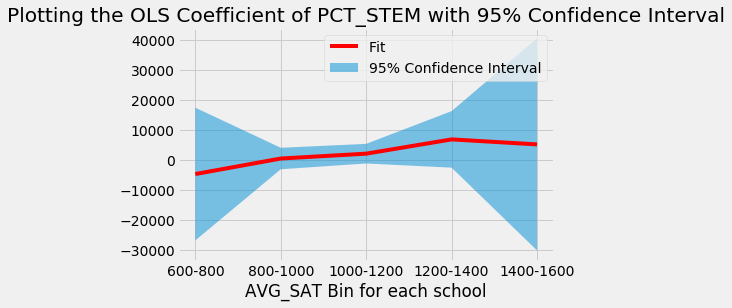

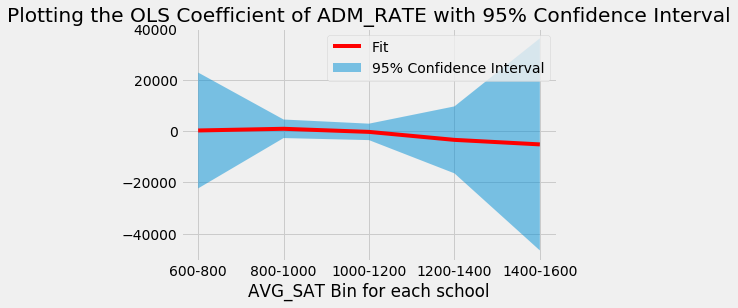

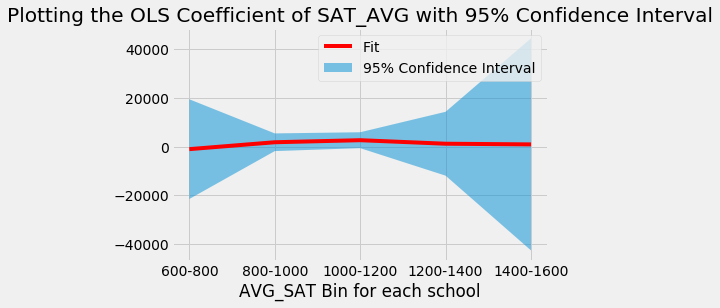

In [25]:
var_list = ['ADM_RATE', 'SAT_AVG', 'PCT_STEM']
def lstq_p(X,y):
    #Runs least squares on X,y
    import statsmodels.api as sm
    from sklearn import preprocessing
    X = preprocessing.scale(X)
    model = sm.OLS(y,X)
    result = model.fit()
    return np.array(result.params),np.array(result.conf_int(0.01)),np.array(result.conf_int(0.05)),np.array(result.pvalues)

def seq_lstq(SAT):
    #Runs least squares on the each element in the list SAT
    results = []
    for df in SAT:
        result=lstq_p(df[var_list].values,df['MD_EARN_WNE_P10'].values)
        results.append(result)
    return results
results = seq_lstq(SAT)
def var_getter(results,var_name='ADM_RATE'):
    #retrieves a list of parameters for a given variables
    var_list = ['ADM_RATE', 'SAT_AVG', 'PCT_STEM']
    idx = var_list.index(var_name)
    relev_params = []
    for result in results:
        sub_result = []
        for param in result:
            sub_result.append(param[idx])
        relev_params.append(sub_result)
    return relev_params


def param_getter(relev_params,param='coef'):
    #Retrieves a certain parameter for a given list of parameters
    possible_params = ['coef','conf_int','conf_int_2','pvalues','r2_adj']
    getter = []
    idx = possible_params.index(param)
    for result in relev_params:
        getter.append(result[idx])
    return getter

def CI_plotter(results,var='PCT_STEM'):
    relev_params = var_getter(results,var)
    coef = param_getter(relev_params,'coef')
    CI = param_getter(relev_params,'conf_int_2')
    low_CI = [item[0] for item in CI]
    high_CI = [item[1] for item in CI]
    fig,ax=plt.subplots()
    plt.plot(coef,color='red',alpha=1.0,label='Fit')
    plt.fill_between(range(len(coef)),low_CI,high_CI,alpha=0.5,label='95% Confidence Interval')
    ax.set_title('Plotting the OLS Coefficient of '+var+' with 95% Confidence Interval')
    plt.xlabel('AVG_SAT Bin for each school')
    plt.xticks(range(len(coef)),['600-800','800-1000','1000-1200','1200-1400','1400-1600','Overall'])
    plt.legend()
CI_plotter(results,'PCT_STEM')
CI_plotter(results,'ADM_RATE')
CI_plotter(results,'SAT_AVG')



Yikes! The Confidence Intervals are so large that the magnitudes of the change in coefficients are miniscule in appearance. Clearly there is a trend, but there is nothing significant about this trend.

Let's do our due diligence one more time. We will run this same analysis but using the Robustness Analysis dataset i.e. using the entire available dataset. Perhaps the larger dataset will decrease our confidence intervals.

In [26]:
###---Taken from Robustness Analysis--###
#preprocessing function
def preprocessing(df):
    #Calculate the Percent of Majors graduated that are STEM
    df.loc[:,'PCT_STEM'] = df[PCIP].sum(axis=1)
    df = df.dropna(subset=['PCT_STEM'],axis=0)
    #convert to numeric type
    for col in df.columns:
        df[col] = pd.to_numeric(df[col],errors='coerce')
    #drop any rows with nan values
    df = df.dropna(subset=['SAT_AVG'],axis=0)
    df = df.dropna(subset=['SAT_AVG','MD_EARN_WNE_P10','ADM_RATE'],axis=0)
    #sort by sat scores
    df = df.sort_values(by='SAT_AVG',ascending=True)
    df = df.reset_index(drop=True)
    assert df[df[['SAT_AVG','ADM_RATE','MD_EARN_WNE_P10']].isnull().values].empty==True
    return df
#splits df into different SAT bins
def SAT_score_splitter(df):
    SAT_6_8 = df[df['SAT_AVG']<800]
    SAT_8_10 = df[(df['SAT_AVG']<1000)&(df['SAT_AVG']>800)]
    SAT_10_12 = df[(df['SAT_AVG']<1200)&(df['SAT_AVG']>1000)]
    SAT_12_14 = df[(df['SAT_AVG']<1400)&(df['SAT_AVG']>1200)]
    SAT_14_16 = df[df['SAT_AVG']>1400]
    SAT = [SAT_6_8,SAT_8_10,SAT_10_12,SAT_12_14,SAT_14_16]
    return SAT
#Importing data
#due to size of file, we will only import certain columns which are relevant to this analysis
relev_col = [0,1,2,3,4,5]+list(range(36,99))+list(range(1637,1645))
#we use the 2013-2014 data because it is the most recent dataset with median earning data
df_1 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2013_14_PP.csv',usecols=relev_col)
df_2 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2012_13_PP.csv',usecols=relev_col)
df_3 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2011_12_PP.csv',usecols=relev_col)
df_4 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2010_11_PP.csv',usecols=relev_col)
df_5 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2009_10_PP.csv',usecols=relev_col)
df_6 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2008_09_PP.csv',usecols=relev_col)
df_7 = pd.read_csv('CollegeScorecard_Raw_Data\MERGED2007_08_PP.csv',usecols=relev_col)
df_all = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7],axis=0)

C:\Users\charl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


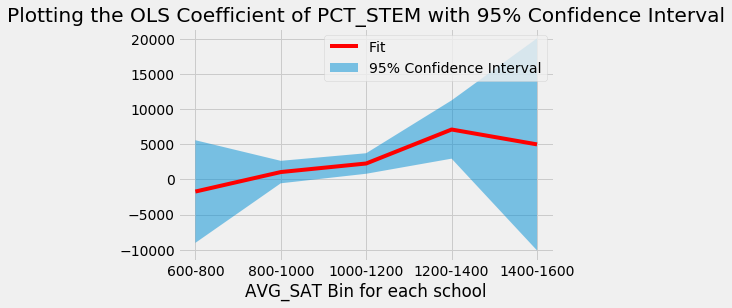

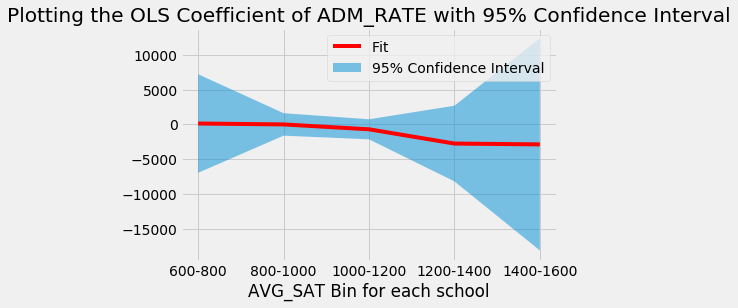

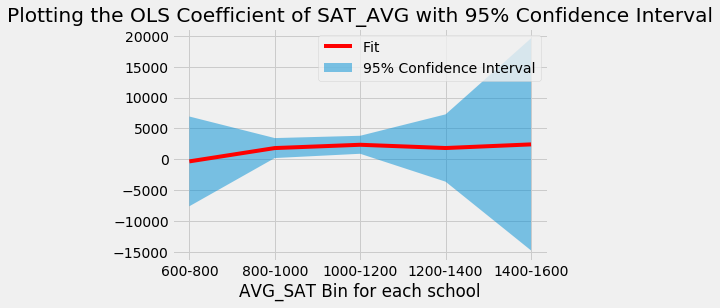

In [27]:
df_all = preprocessing(df_all)
SAT_all = SAT_score_splitter(df_all)
results_all = seq_lstq(SAT_all)
CI_plotter(results_all,'PCT_STEM')
CI_plotter(results_all,'ADM_RATE')
CI_plotter(results_all,'SAT_AVG')

Unfortunately, even the larger dataset does not significantly diminish the confidence interval size to the point where we can claim a clear trend or interpretation. Most troublingly, the confidence interval is often roughly centered around 0, so that we cannot even be confident in the sign of coefficient. Ultimately, this was a good exercise for me, and hopefully a good example for you, of the dangers of trusting average values without fully exploring the dataset. Data Science is, for better or worse, one of the most democratic and open sciences, as the advent of Open and Big Data means that anyone can check your work or expose shortcominigs in an analysis. We owe it to the community and to ourselves to present our work in as honest and open a fashion as we can.